<a href="https://colab.research.google.com/github/spetti/SMURF/blob/main/examples/nw_speedtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
#os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import time

In [3]:
def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

In [4]:
def nw_naive(temp=1.0, unroll=10, batch=True, deepblast_bug=False):
  def sco(x, gap=0):
    def _soft_maximum(x,axis=0):
      return temp*jax.nn.logsumexp(x/temp,axis)
    # fill the scoring matrix
    def rows(pr,r):
      def cols(pc,c):
        # |------|-------|
        # | pc[0]| pc[1] |
        # |------|-------|
        # | c[0] | c[1]  |
        # |------|-------|
        if deepblast_bug:
          Align = pc[0] + c[1]
          Right = c[0]  + c[1] + gap
          Down  = pc[1] + c[1] + gap
        else:
          Align = pc[0] + c[1]
          Right = c[0]  + gap
          Down  = pc[1] + gap

        H = _soft_maximum(jnp.stack([Align, Right, Down]))
        return (c[0],H),H
      pr_r = jax.lax.scan(cols,(pr[1],r[1]),(pr[0],r[0]),unroll=unroll)[1]
      return (pr_r,r[1]), pr_r
    if deepblast_bug:
      ini_col = jnp.zeros(x.shape[0])
      ini_row = jnp.zeros(x.shape[1])
    else:
      ini_col = gap * jnp.arange(1,x.shape[0]+1,dtype=jnp.float32)
      ini_row = gap * jnp.arange(1,x.shape[1]+1,dtype=jnp.float32)
    hij = jax.lax.scan(rows,(ini_row,0),(x,ini_col))[1]

    return hij[-1,-1]
  # traceback to get alignment (aka. get marginals)
  traceback = jax.grad(sco)
  
  # add batch dimension
  if batch: return jax.vmap(traceback)
  else: return traceback

In [5]:
def nw(unroll=2):
  # rotate matrix for vectorized dynamic-programming
  def rotate(x, lengths, gap, temp):
    def _ini_global(L):
      return gap*jnp.arange(L)

    a,b = x.shape
    real_a, real_b = lengths
    mask = (jnp.arange(a)<real_a)[:,None] * (jnp.arange(b)<real_b)[None,:]
    
    real_L = lengths
    mask = jnp.pad(mask,[[1,0],[1,0]])
    x = jnp.pad(x,[[1,0],[1,0]])
    
    # solution from jake vanderplas (thanks!)
    a,b = x.shape
    ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
    i,j = (br-ar)+(a-1),(ar+br)//2
    n,m = (a+b-1),(a+b)//2
    zero = jnp.zeros((n,m))
    output = {"x":zero.at[i,j].set(x),
              "mask":zero.at[i,j].set(mask),
              "o":(jnp.arange(n)+a%2)%2}
    
    ini_a, ini_b = _ini_global(a), _ini_global(b)      
    ini = jnp.zeros((a,b)).at[:,0].set(ini_a).at[0,:].set(ini_b)
    output["ini"] = zero.at[i,j].set(ini)

    return {"x":output,
            "prev":(jnp.zeros(m),jnp.zeros(m)),
            "idx":(i,j),
            "mask":mask,
            "L":real_L}

  # fill the scoring matrix
  def sco(x, lengths, gap=0.0, temp=1.0):

    def _logsumexp(x, axis=None, mask=None):
      if mask is None: return jax.nn.logsumexp(x,axis=axis)
      else: return x.max(axis) + jnp.log(jnp.sum(mask * jnp.exp(x - x.max(axis,keepdims=True)),axis=axis))

    def _soft_maximum(x, axis=None, mask=None):
      return temp*_logsumexp(x/temp, axis, mask)

    def _cond(cond, true, false):
      return cond*true + (1-cond)*false

    def _step(prev, sm): 
      h2,h1 = prev   # previous two rows of scoring (hij) mtx
      
      Align = h2 + sm["x"]
      Turn = _cond(sm["o"],jnp.pad(h1[:-1],[1,0]),jnp.pad(h1[1:],[0,1]))
      h0 = [Align, h1+gap, Turn+gap]
      h0 = jnp.stack(h0)
      h0 = sm["mask"] * _soft_maximum(h0,0)
      h0 += sm["ini"]
      return (h1,h0),h0

    a,b = x.shape
    sm = rotate(x, lengths=lengths, gap=gap, temp=temp)
    hij = jax.lax.scan(_step, sm["prev"], sm["x"], unroll=unroll)[-1][sm["idx"]]

    return hij[sm["L"][0],sm["L"][1]]

  # traceback to get alignment (aka. get marginals)
  traceback = jax.grad(sco)

  # add batch dimension
  return jax.vmap(traceback,(0,0,None,None))

In [6]:
def sw(unroll=2, batch=True, NINF=-1e30):
  '''smith-waterman (local alignment)'''

  # rotate matrix for striped dynamic-programming
  def rotate(x):   
    # solution from jake vanderplas (thanks!)
    a,b = x.shape
    ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
    i,j = (br-ar)+(a-1),(ar+br)//2
    n,m = (a+b-1),(a+b)//2
    output = {"x":jnp.full([n,m],NINF).at[i,j].set(x), "o":(jnp.arange(n)+a%2)%2}
    return output, (jnp.full(m, NINF), jnp.full(m, NINF)), (i,j)

  # comute scoring (hij) matrix
  def sco(x, lengths, gap=0, temp=1.0):

    def _soft_maximum(x, axis=None, mask=None):
      def _logsumexp(y):
        if mask is None: return jax.nn.logsumexp(y, axis=axis)
        else: return y.max(axis) + jnp.log(jnp.sum(mask * jnp.exp(y - y.max(axis, keepdims=True)), axis=axis))
      return temp*_logsumexp(x/temp)
    
    def _cond(cond, true, false): return cond*true + (1-cond)*false
    def _pad(x,shape): return jnp.pad(x,shape,constant_values=(NINF,NINF))

    def _step(prev, sm):      
      h2,h1 = prev   # previous two rows of scoring (hij) mtx
      h1_T = _cond(sm["o"],_pad(h1[:-1],[1,0]),_pad(h1[1:],[0,1]))
      
      # directions
      Align = h2 + sm["x"]
      Turn_0 = h1 + gap
      Turn_1 = h1_T + gap
      Sky = sm["x"]

      h0 = jnp.stack([Align, Turn_0, Turn_1, Sky], -1)
      h0 = _soft_maximum(h0, -1)
      return (h1,h0),h0

    # mask
    a,b = x.shape
    real_a, real_b = lengths
    mask = (jnp.arange(a) < real_a)[:,None] * (jnp.arange(b) < real_b)[None,:]
    x = x + NINF * (1 - mask)

    sm, prev, idx = rotate(x[:-1,:-1])
    hij = jax.lax.scan(_step, prev, sm, unroll=unroll)[-1][idx]
    return _soft_maximum(hij + x[1:,1:], mask=mask[1:,1:])

  # traceback (aka backprop) to get alignment
  traceback = jax.grad(sco)

  # add batch dimension
  if batch: return jax.vmap(traceback,(0,0,None,None))
  else: return traceback

In [7]:
def test(app, app_mode="jax", mode="len", trials=1, add_lengths=False):
  compile_time = []
  run_time = []
  for k in range(100,1000,100):
    if mode == "len": shape = [128,k,k]
    if mode == "batch": shape = [k,256,256]
    if app_mode == "jax":
      clear_mem()
      data = jnp.ones(shape,dtype=jnp.float32)
    if app_mode == "torch":
      torch.cuda.empty_cache()
      data = torch.ones(shape,dtype=torch.float32).cuda()

    if add_lengths and app_mode == "jax":
      if mode == "len":
        lens = jnp.full((128,2),k,dtype=jnp.int32)
      if mode == "batch":
        lens = jnp.full((k,2),256,dtype=jnp.int32)

    t = time.time()
    if add_lengths and app_mode == "jax":
      _ = app(data, lens, 0.0, 1.0)
    else:
      _ = app(data)
    compile_time.append(time.time() - t)
    t = time.time()
    for _ in range(trials):
      if add_lengths and app_mode == "jax":
        _ = app(data, lens, 0.0, 1.0)
      else:
        _ = app(data)
    run_time.append((time.time() - t)/trials)
    print(k,compile_time[-1]-run_time[-1],run_time[-1])
  return np.array([compile_time,run_time])

In [8]:
!pip -q install deepblast

In [9]:
import torch
from deepblast.nw_cuda import NeedlemanWunschDecoder
import time

In [10]:
needle_cuda = NeedlemanWunschDecoder("softmax")
needle_cuda.cuda()

NeedlemanWunschDecoder()

In [11]:
def forward_test(theta, gap=0):
  theta.requires_grad_()
  gap_mtx = torch.full_like(theta, fill_value=gap, dtype=torch.float32)
  sco = needle_cuda(theta, gap_mtx).sum()
  sco.backward()
  path = theta.grad
  return path

In [12]:
nw_pytorch_time_fwd_len = test(forward_test, app_mode="torch", mode="len")

100 0.7440214157104492 0.027087926864624023
200 0.007931709289550781 0.09360480308532715
300 -0.00141143798828125 0.2096395492553711
400 0.002173900604248047 0.3826141357421875
500 -0.001550912857055664 0.6061217784881592
600 0.001459360122680664 0.8743841648101807
700 0.0035369396209716797 1.1967964172363281
800 -0.0011112689971923828 1.5762219429016113
900 0.0004761219024658203 2.006563425064087


In [13]:
nw_pytorch_time_fwd_batch = test(forward_test, app_mode="torch", mode="batch")

100 0.017751455307006836 0.1475069522857666
200 0.0007884502410888672 0.16380739212036133
300 0.000701904296875 0.17494678497314453
400 0.0026502609252929688 0.19242191314697266
500 0.0005185604095458984 0.20257115364074707
600 0.00048351287841796875 0.21465086936950684
700 -3.409385681152344e-05 0.22414755821228027
800 9.036064147949219e-05 0.232741117477417
900 0.00024271011352539062 0.24182820320129395


In [14]:
torch.cuda.empty_cache()

In [15]:
nw_naive_jax_time_fwd_len = test(jax.jit(nw_naive()), mode="len")
nw_jax_time_fwd_len = test(jax.jit(nw()), mode="len", add_lengths=True)

100 1.6804094314575195 0.15738272666931152
200 1.7889583110809326 0.5756914615631104
300 1.6748685836791992 1.2071900367736816
400 1.7827200889587402 2.1250972747802734
500 1.616607904434204 3.329932689666748
600 1.703833818435669 4.767180681228638
700 1.5933334827423096 6.5110390186309814
800 1.7958364486694336 8.418237924575806
900 1.4589629173278809 10.947627305984497
100 1.9052269458770752 0.009003877639770508
200 1.777158498764038 0.023798227310180664
300 1.7581984996795654 0.04417133331298828
400 1.8903303146362305 0.06792140007019043
500 1.7733933925628662 0.09989356994628906
600 1.8002498149871826 0.1349031925201416
700 1.7404332160949707 0.17775535583496094
800 1.7575788497924805 0.22441792488098145
900 1.9147107601165771 0.28098249435424805


In [16]:
sw_jax_time_fwd_len = test(jax.jit(sw()), mode="len", add_lengths=True)

100 2.4687371253967285 0.008494138717651367
200 2.122877597808838 0.022876262664794922
300 2.1645686626434326 0.04282045364379883
400 2.2558205127716064 0.06867480278015137
500 2.515486717224121 0.1055147647857666
600 2.341676950454712 0.14378619194030762
700 2.399528980255127 0.1937713623046875
800 2.480354070663452 0.24724531173706055
900 2.6173202991485596 0.30335426330566406


In [17]:
nw_naive_jax_time_fwd_batch = test(jax.jit(nw_naive()), mode="batch")
nw_jax_time_fwd_batch = test(jax.jit(nw()), mode="batch", add_lengths=True)

100 2.3535969257354736 0.9218485355377197
200 2.4479777812957764 0.9677252769470215
300 2.382394552230835 0.9215891361236572
400 2.290809154510498 0.9717299938201904
500 2.262277603149414 0.9905514717102051
600 2.3241055011749268 0.9770371913909912
700 2.3250913619995117 0.9509742259979248
800 2.3609976768493652 1.0085468292236328
900 2.628316640853882 0.9261138439178467
100 1.800239086151123 0.0282742977142334
200 1.8869647979736328 0.0407257080078125
300 1.8184409141540527 0.05592060089111328
400 1.7787795066833496 0.06910562515258789
500 1.8211636543273926 0.08510303497314453
600 1.787919521331787 0.10189342498779297
700 1.8299903869628906 0.12289118766784668
800 2.0877950191497803 0.13897347450256348
900 1.8062341213226318 0.15663743019104004


In [18]:
sw_jax_time_fwd_batch = test(jax.jit(sw()), mode="batch", add_lengths=True)

100 2.2279727458953857 0.029741287231445312
200 2.1668035984039307 0.044835805892944336
300 2.137260675430298 0.0605168342590332
400 2.137781858444214 0.07698750495910645
500 2.161875009536743 0.09531283378601074
600 2.1458024978637695 0.11139726638793945
700 2.1447129249572754 0.13095855712890625
800 2.429471015930176 0.15216064453125
900 2.1383719444274902 0.17412400245666504


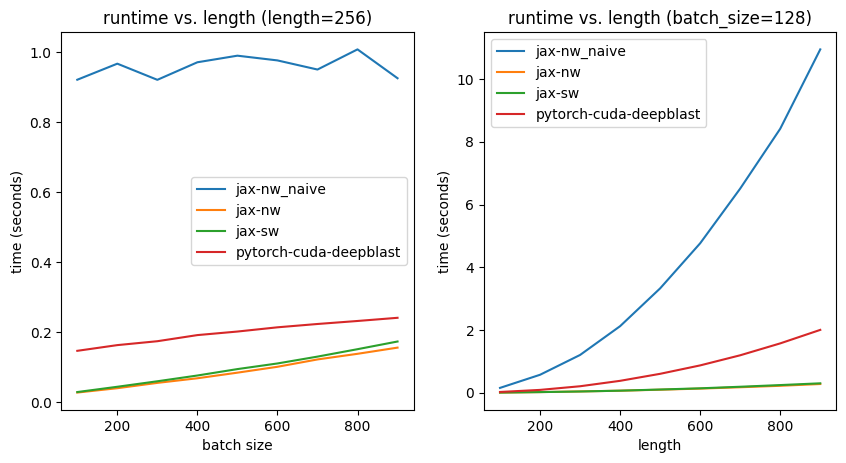

In [21]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(1,2,1)
plt.title("Runtime vs. batch size (length=256)")
plt.plot(np.arange(100,1000,100),nw_naive_jax_time_fwd_batch[1],label="jax-nw_naive")
plt.plot(np.arange(100,1000,100),nw_jax_time_fwd_batch[1],label="jax-nw")
plt.plot(np.arange(100,1000,100),sw_jax_time_fwd_batch[1],label="jax-sw")
plt.plot(np.arange(100,1000,100),nw_pytorch_time_fwd_batch[1],label="pytorch-cuda-deepblast")
plt.xlabel("Batch size")
plt.ylabel("Time (seconds)")
#plt.yscale("log")
#plt.legend()

plt.subplot(1,2,2)
plt.title("Runtime vs. length (batch_size=128)")
plt.plot(np.arange(100,1000,100),nw_naive_jax_time_fwd_len[1],label="jax-nw_naive")
plt.plot(np.arange(100,1000,100),nw_jax_time_fwd_len[1],label="jax-nw")
plt.plot(np.arange(100,1000,100),sw_jax_time_fwd_len[1],label="jax-sw")
plt.plot(np.arange(100,1000,100),nw_pytorch_time_fwd_len[1],label="pytorch-cuda-deepblast")
plt.xlabel("Length")
plt.ylabel("Time (seconds)")
#plt.yscale("log")
plt.legend()
plt.savefig("speedtest.pdf",bbox_inches='tight')